<a href="https://colab.research.google.com/github/siposroland/cvs_hw_3d/blob/master/CV_HW_TASK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# installing Requirements
!pip install torch torchvision

# Download dataset

In [0]:
# Homework dataset
!wget http://deeplearning.iit.bme.hu/CVS/HW.zip
!unzip -qq HW.zip
!rm HW.zip

# Traffic Sign Classification set
#!wget http://deeplearning.iit.bme.hu/CVS/trafficSignsHW.zip
#!unzip -qq trafficSignsHW.zip
#!rm trafficSignsHW.zip

# Saját Dataset

In [0]:
#!wget https://drive.google.com/file/d/18gk-2hTc87k5yygWKoFiMLeSFId7uRo3/view?usp=sharing -o trafficSignsHWSajat.zip
#!unzip -qq trafficSignsHWSajat.zip

#valamiért nem tölti le a teljes fájlt


Model letöltése

In [0]:
!wget https://github.com/siposroland/cvs_hw_3d/raw/master/model.pth


Class names


In [0]:
classNames = ['traffic sign', 'vehicle', 'cactus']
subclassNames = [
    ['Bump', 'Bumpy road', 'Bus stop', 'Children', 'Crossing (blue)', 'Crossing (red)', 'Cyclists',
     'Danger (other)', 'Dangerous left turn', 'Dangerous right turn', 'Give way', 'Go ahead', 'Go ahead or left',
     'Go ahead or right', 'Go around either way', 'Go around left', 'Go around right', 'Intersection', 'Limit 100',
     'Limit 120', 'Limit 20', 'Limit 30', 'Limit 50', 'Limit 60', 'Limit 70', 'Limit 80', 'Limit 80 over',
     'Limit over', 'Main road', 'Main road over', 'Multiple dangerous turns', 'Narrow road (left)',
     'Narrow road (right)', 'No entry', 'No entry (both directions)', 'No entry (truck)', 'No stopping', 'No takeover',
     'No takeover (truck)', 'No takeover (truck) end', 'No takeover end', 'No waiting', 'One way road',
     'Parking', 'Road works', 'Roundabout', 'Slippery road', 'Stop', 'Traffic light', 'Train crossing',
     'Train crossing (no barrier)', 'Wild animals', 'X - Priority', 'X - Turn left', 'X - Turn right'],
    ['SUV','truck','plane'],
    ['happy','sad','angry','evil']
]

# Neural network

In [0]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch import optim

# Convolutional module (Conv+ReLU+BatchNorm)
class Conv(nn.Module):
  def __init__(self, in_channels, channels,kernel_size=3, stride=1):   #kernel_size=3
     super(Conv, self).__init__()
     self.conv = nn.Conv2d(in_channels, channels, kernel_size, stride=stride, padding=kernel_size//2, bias=False)   #padding=1
     self.bn = nn.BatchNorm2d(channels)
  def forward(self,x):
     return self.bn(torch.relu(self.conv(x)))
  

class ConvNet(nn.Module):
  def __init__(self, base_channels=16, in_channels=3, num_classes=55):  #in_channels=4
      super(ConvNet, self).__init__()   
      
      self.c11 = Conv(in_channels, base_channels)
      self.c12 = Conv(base_channels, base_channels)
      self.d1 = Conv(base_channels, base_channels*2, stride=2)

      self.c21 = Conv(base_channels*2, base_channels*2)
      self.c22 = Conv(base_channels*2, base_channels*2)
      self.d2 = Conv(base_channels*2, base_channels*4, stride=2)
        
      self.c31 = Conv(base_channels*4, base_channels*4)
      self.c32 = Conv(base_channels*4, base_channels*4)
      self.d3 = Conv(base_channels*4, base_channels*8, stride=2)
        
      self.c41 = Conv(base_channels*8, base_channels*8)
      self.c42 = Conv(base_channels*8, base_channels*8)
      self.d4 = Conv(base_channels*8, base_channels*16, stride=2)
        
      self.c51 = Conv(base_channels*16, base_channels*16)
      self.c52 = Conv(base_channels*16, base_channels*16)
      self.d5 = Conv(base_channels*16, base_channels*32, stride=2)
      # Input image is 32x32 -> after 5 downscaling the activation map is 1x1
      
      # Classifier is a convolution that produces num_classes class scores
      self.classifier = nn.Conv2d(base_channels*32,num_classes, 1) #kernel_size=1

  def forward(self,x):
        # Class all the layers
        x = self.d1(self.c12(self.c11(x)))
        x = self.d2(self.c22(self.c21(x)))
        x = self.d3(self.c32(self.c31(x)))
        x = self.d4(self.c42(self.c41(x)))
        x = self.d5(self.c52(self.c51(x)))
        return torch.squeeze(self.classifier(x))


haveCuda = torch.cuda.is_available()

#DATA AUGMENTATION
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
     #transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)) # mean = 0 and standard-deviation = 1
])

transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    # Random perturbance of brightness, contrast and color
    transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=0.3,hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                         (0.24703233, 0.24348505, 0.26158768))
    #transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)) # mean = 0 and standard-deviation = 1
])

#DATASETS
#trainSet = torchvision.datasets.ImageFolder(root="/content/trafficSignsHW/trainFULL", transform=transform)
#testSet = torchvision.datasets.ImageFolder(root="/content/trafficSignsHW/testFULL", transform=transform_val) #is_valid_file=None

#trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True) #sampler overfitting kevés adatra bs=128
#testLoader = torch.utils.data.DataLoader(testSet, batch_size=32, shuffle=False)


def createNet():
    net = ConvNet()
    if haveCuda:
        net = net.cuda()
    return net

def createLoss():
    return nn.CrossEntropyLoss()

# create optimizer
def createOptimizer():
    return optim.SGD(net.parameters(), lr=1e-2, momentum=0.5)  # lr=1e-1, momentum=0.9,nesterov=True, weight_decay=1e-4

numEpoch =20

def createScheduler():
    return optim.lr_scheduler.CosineAnnealingLR(optimizer,numEpoch,eta_min=1e-2)


#Progress bar
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))



def train(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    # set the network to train (for batchnorm and dropout)
    net.train()

    # Create progress bar
    bar = display(progress(0, len(trainLoader)), display_id=True)

    for i, data in enumerate(trainLoader, 0):
        
        inputs, labels = data
        if haveCuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        # Forward
        outputs = net(inputs)
        # Loss
        loss = criterion(outputs, labels)  #loss = torch.nn.functional.nll_loss(outputs, labels)
        # Backpropagation
        loss.backward()
        # Gradient method
        optimizer.step()

        # Do not include these steps in the computational graph
        with torch.no_grad():
            # Accumulate loss
            running_loss += loss.item()
            # Get indices of the largest goodness values
            _, predicted = torch.max(outputs, 1)
            # Count how many of the predictions equal the labels
            correct += predicted.eq(labels).sum().item()
            # Accumulate number of total images seen
            total += labels.shape[0]   ####

        # Progress bar
        bar.update(progress(i+1, len(trainLoader)))

    # return loss and accuracy
    tr_loss = running_loss / i
    tr_corr = correct / total * 100
    print("Train epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, tr_corr))
    return tr_loss,tr_corr

# Function for validating a single epch
def val(epoch):

    # variables for loss
    running_loss = 0.0
    correct = 0.0
    total = 0

    # set the network to eval  (for batchnorm and dropout)
    net.eval()

    # Create progress bar
    bar = display(progress(0, len(testLoader)), display_id=True)

    for i, data in enumerate(testLoader, 0):
        # get the inputs
        inputs, labels = data
        if haveCuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # Do not include these steps in the computational graph
        with torch.no_grad():
            # Forward
            outputs = net(inputs)
            # Compute loss
            loss = criterion(outputs, labels)

            # Compute statistics, just like before
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += predicted.eq(labels).sum().item()
            total += labels.shape[0]

        bar.update(progress(i+1, len(testLoader)))

    # return loss and accuracy
    val_loss = running_loss / i
    val_corr = correct / total * 100
    print("Test epoch %d loss: %.3f correct: %.2f" % (epoch + 1, running_loss / i, val_corr))
    return val_loss,val_corr



# Main

In [0]:
#MAIN LOOP
# Containers for losses and accuracies for every epoch
train_accs = []
train_losses = []
val_accs = []
val_losses = []

# Best validation accuracy
best_acc = 0

# Set pseudo-random generator seeds to make multiple runs comparable
torch.manual_seed(42)
if haveCuda:
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic= True
    torch.backends.cudnn.benchmark= False
# Create net, criterion, optimizer and scheduler
# This needs to be done after setting the random seed, 
# so that the random initialization would be the same
net = createNet()
criterion = createLoss()
optimizer = createOptimizer()
scheduler = createScheduler()

# For numEpoch epochs
for epoch in range(numEpoch): 
    
    # Train
    loss,acc = train(epoch)
    train_accs.append(acc)
    train_losses.append(loss)
    
    # Validate
    loss,acc = val(epoch)
    val_accs.append(acc)
    val_losses.append(loss)
    
    # Step with the LR scheduler
    scheduler.step()
    
    # If the current model is better, than the previous best, save it
    if acc > best_acc:
        print("Best Model, Saving")
        best_acc = acc
        torch.save(net,"./model.pth")

Train epoch 1 loss: 0.670 correct: 80.52


Test epoch 1 loss: 0.100 correct: 97.06
Best Model, Saving


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Train epoch 2 loss: 0.097 correct: 97.14


Test epoch 2 loss: 0.059 correct: 98.25
Best Model, Saving


Train epoch 3 loss: 0.062 correct: 98.16


Test epoch 3 loss: 0.050 correct: 98.51
Best Model, Saving


Train epoch 4 loss: 0.047 correct: 98.60


Test epoch 4 loss: 0.043 correct: 98.75
Best Model, Saving


Train epoch 5 loss: 0.039 correct: 98.85


Test epoch 5 loss: 0.060 correct: 98.36


Train epoch 6 loss: 0.034 correct: 99.00


Test epoch 6 loss: 0.039 correct: 98.97
Best Model, Saving


Train epoch 7 loss: 0.028 correct: 99.18


Test epoch 7 loss: 0.026 correct: 99.28
Best Model, Saving


Train epoch 8 loss: 0.025 correct: 99.27


Test epoch 8 loss: 0.021 correct: 99.41
Best Model, Saving


Train epoch 9 loss: 0.024 correct: 99.30


Test epoch 9 loss: 0.025 correct: 99.31


Train epoch 10 loss: 0.022 correct: 99.37


Test epoch 10 loss: 0.026 correct: 99.29


Train epoch 11 loss: 0.019 correct: 99.41


Test epoch 11 loss: 0.023 correct: 99.38


Train epoch 12 loss: 0.020 correct: 99.40


Test epoch 12 loss: 0.022 correct: 99.36


Train epoch 13 loss: 0.017 correct: 99.50


Test epoch 13 loss: 0.019 correct: 99.50
Best Model, Saving


Train epoch 14 loss: 0.018 correct: 99.50


Test epoch 14 loss: 0.019 correct: 99.44


Train epoch 15 loss: 0.016 correct: 99.53


Test epoch 15 loss: 0.024 correct: 99.27


Train epoch 16 loss: 0.015 correct: 99.55


Test epoch 16 loss: 0.018 correct: 99.50


Train epoch 17 loss: 0.015 correct: 99.56


Test epoch 17 loss: 0.018 correct: 99.48


Train epoch 18 loss: 0.014 correct: 99.56


Test epoch 18 loss: 0.020 correct: 99.45


Train epoch 19 loss: 0.013 correct: 99.59


Test epoch 19 loss: 0.017 correct: 99.50


Train epoch 20 loss: 0.014 correct: 99.56


Test epoch 20 loss: 0.017 correct: 99.47


# Plot graphs

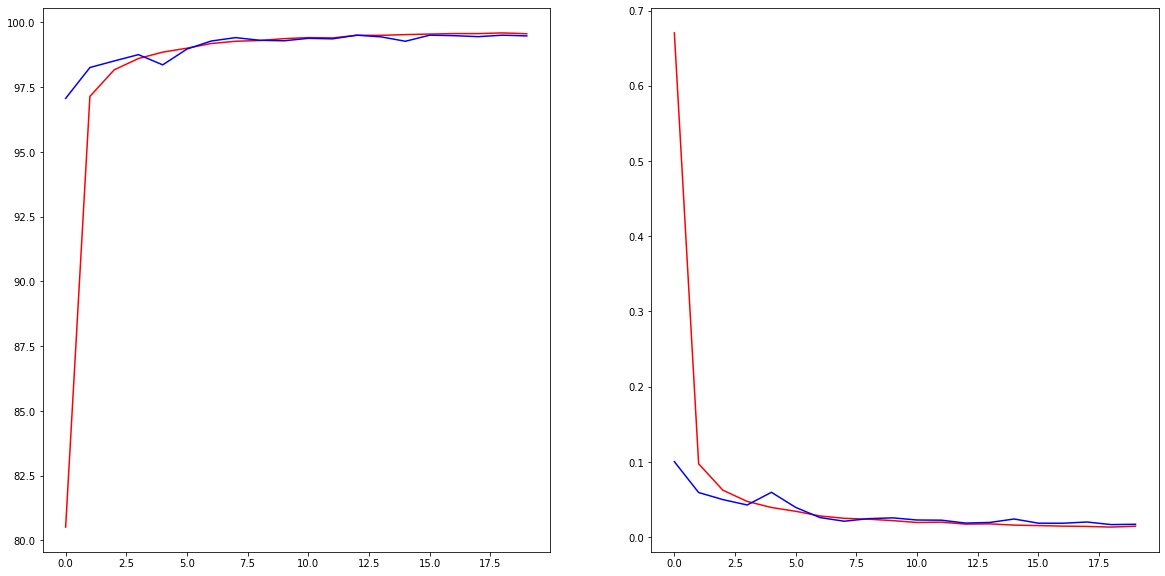

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# X coordinate for plotting
x = np.arange(numEpoch)

plt.figure(figsize=(20,10))

# Train is red, validation is blue
plt.subplot(1,2,1)
plt.plot(x,train_accs,'r')
plt.plot(x,val_accs,'b')

plt.subplot(1,2,2)
plt.plot(x,train_losses,'r')
plt.plot(x,val_losses,'b')

plt.show()




# Croping image from annotations.pickle

[[92, 389, 119, 135, 1, 0, -0.20919618260507536, -0.13468296888435302, 0.5700000000000001], [574, 409, 132, 140, 1, 2, 0.26940410296838896, -0.16941771480617554, 0.629], [419, 319, 131, 244, 2, 2, 0.09283199808570307, -0.06487242262905885, 0.538], [146, 154, 121, 213, 2, 1, -0.21371204051283985, 0.11700563579597315, 0.769], [531, 198, 111, 164, 2, 0, 0.30982588317189175, 0.06886059943783786, 0.867], [296, 142, 31, 33, 0, 53, -0.026937914056849224, 0.15238150038432874, 0.886], [343, 143, 31, 33, 0, 23, 0.040971280913206655, 0.1480213044437564, 0.869], [321, 110, 31, 31, 0, 44, 0.009350007966166252, 0.19384824497605802, 0.862], [280, 112, 34, 31, 0, 5, -0.04964713811197227, 0.19365750431770826, 0.874]]
Image predicted as:  X - Turn left
Image predicted as:  Limit 60
Image predicted as:  Road works
Image predicted as:  Crossing (red)


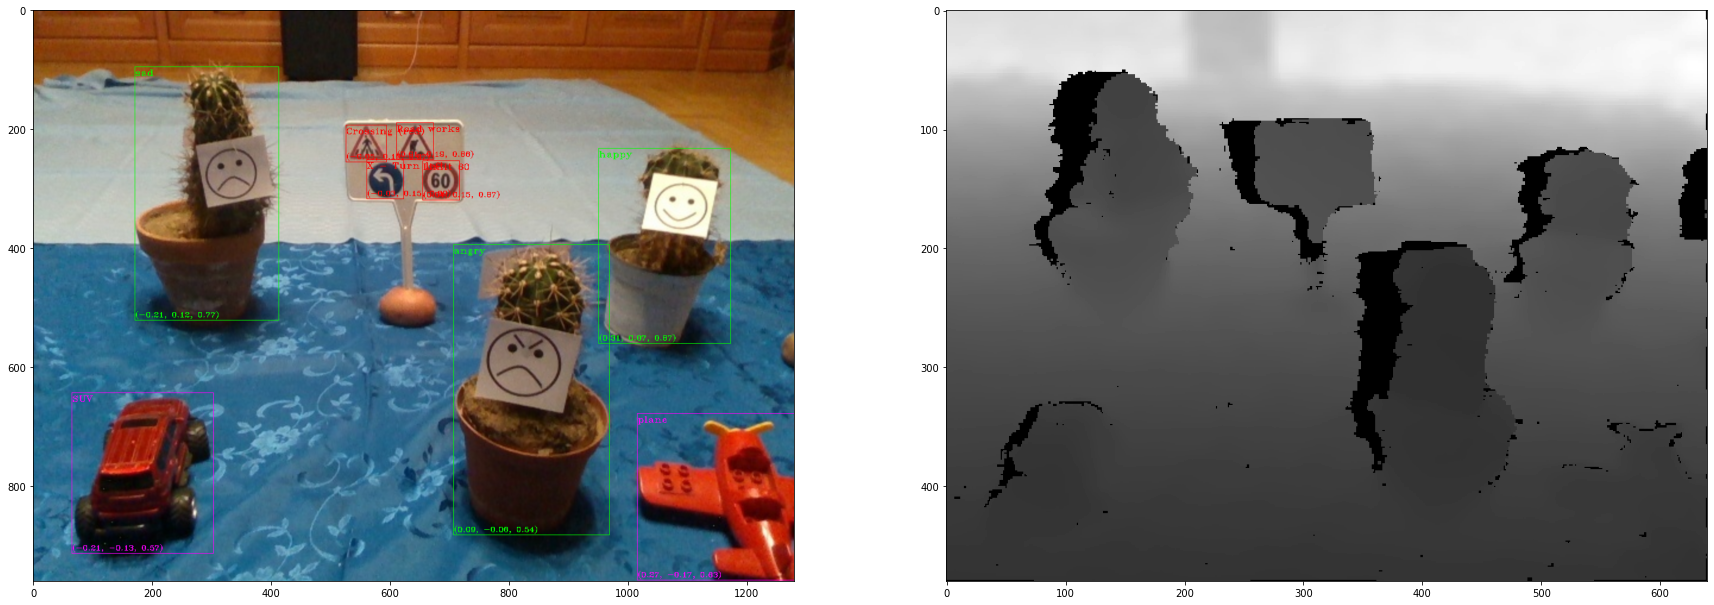

In [19]:

colors = [(0,0,255),(255,0,255),(0,255,0)]

def drawBBs(BBs, img):
    img = cv2.resize(img, (1280, 960))
    #i=0
    for BB in BBs:
        u = BB[0]*2
        v = BB[1]*2
        w = BB[2]*2
        h = BB[3]*2
        c = BB[4]
        sc = BB[5]
        x = BB[6]
        y = BB[7]
        z = BB[8]
        s = (u - w // 2, v - h // 2)
        e = (u + w // 2, v + h // 2)
        if c==0:     
           
          #if class is traffic sign then
          crop_image = img[v-w//2:v+w//2, u-h//2:u+h//2]
          rs_img=cv2.resize(crop_image, (32,32), interpolation = cv2.INTER_AREA)
          rs_img_rgb= cv2.cvtColor(rs_img,cv2.COLOR_BGR2RGB)
          dl_img = transform(rs_img_rgb)  # Preprocess image
          dl_img = dl_img.unsqueeze(0)  # Add batch dimension
          if haveCuda:
            dl_img=dl_img.cuda()
          output = model(dl_img)  # Forward pass
          _, pred = torch.max(output, 0)  # Get predicted class
          print('Image predicted as: ', subclassNames[0][pred.item()])
          #end

        cv2.rectangle(img, s, e, colors[c], 1)
        tl = (s[0], s[1]+15)
        bl = (s[0], e[1]-5)
        cv2.putText(img,subclassNames[c][sc],tl,cv2.FONT_HERSHEY_COMPLEX_SMALL,0.75,colors[c])
        coords = "(%.2f, %.2f, %.2f)" % (x,y,z)
        cv2.putText(img,coords,bl,cv2.FONT_HERSHEY_COMPLEX_SMALL,0.65,colors[c])
    
    return img

import pickle
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch import optim
import numpy as np
%matplotlib inline



#Deep learning 
transform = transforms.Compose([transforms.ToTensor()]) 
#Read model
model = torch.load("./model.pth")
model.eval()






# Read images
img = cv2.imread("HW/g2/rgb/108.jpg")
depth = cv2.imread("HW/g2/depth/108.png", -1)

# Read annotations
file = open('HW/annotations.pickle','rb')
annotations = pickle.load(file)
print (annotations["HW/g2/rgb/108.jpg"]["objects"])

# Visualization
depth = depth / 5000.0
img = drawBBs(annotations["HW/g2/rgb/108.jpg"]["objects"], img)
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Figure with subplots
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.subplot(1,2,2)
plt.imshow(depth,cmap='gray')